# Track 2: SIR Model

Lorem Ipsum

## Modelling epidemic spread of disease with the SIR model

Lorem Ipsum

In [ ]:
#first we install the package (in case it is not done yet) and import the Simulation class
%pip install -e .

pygame 2.4.0 (SDL 2.26.4, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [45]:
import numpy as np
from pygmodw23.sims import Simulation


# Simulation Parameters
# simulation time
T = 2000
# max visualization framerate (also depends on your computer)
framerate = 2000
# You can speed up the simulation a lot by turning off the visualization
# and simultaneously set the framerate to a very high value, e.g. 2000
with_visualization = False
# number of agents
N = 200

# how many timesteps should be saved (slightly slows simulation)
# You should have at least a few hundred MB free memory (RAM)
memory_length = T

# showing agent trajectories (significantly slows simulation)
show_agent_trails = False

# arena
width = height = 500
window_pad = 50

# Create a simulation instance
test_simulation = Simulation(N=N, T=T, agent_type="SIR-brownian-selfpropelled", framerate=framerate,
                            width=width, height=height, window_pad=window_pad, with_visualization=with_visualization)

# probability to make an agent moving other remain still
ratio_of_moving_agents = 0.1

# Change Agent Parameters
for agent in test_simulation.agents:
    agent.noise_type = "uniform"  # or "normal"
    
    # Agent movement parameters
    if np.random.rand() < ratio_of_moving_agents:
        agent.v_max = 2
        agent.noise_params = (-0.5, 0.5)  # (min, max) or (mean, std)
    else:
        agent.v_max = 0
        agent.noise_params = (0, 0)  # (min, max) or (mean, std)
    
    # SIR parameters
    agent.infection_prob =   0.01
    agent.recovery_prob =    0.001
    agent.death_prob =       0.001
    agent.infection_radius = 25
    agent.radius =           8


# Initially infecting some agents
num_infected_agents = 3
for agent in test_simulation.agents:
    if agent.id < num_infected_agents:
        agent.state = "I"
    else:
        break
        
    
# showing colorcoded trails if requested
test_simulation.show_agent_trails = show_agent_trails

# saving data if requested
test_simulation.memory_length = memory_length

# showing infective zone
test_simulation.show_zones = True


# Start the simulation
test_simulation.start()

Running simulation start method!
Starting main simulation loop!
2023-06-06_20-53-49.893704 Total simulation time:  30.985592


## Saving data to HDF5 files and visualizing disease spread

As before we can save the resulting data from the memory to HDF5 files. Additionally to the data in Track1, in this Track we can also save the states of the agents over time. Here is an example how:

In [46]:
# Import h5py and save ori_memory to hdf5 file
import h5py

# Create a single H5 file to contain our arrays
h5f = h5py.File('agent_states.h5', 'w')

# Save orientation and position memory (trails) into different datasets in the same file
h5f.create_dataset('agent_states', data=test_simulation.agent_states[:, ::-1])

# Close the file
h5f.close()

# Read saved data from HDF5 file
h5f = h5py.File('agent_states.h5','r')

# Read individual datasets into python variables
agent_states = h5f['agent_states'][:]

# close file after read
h5f.close()

# check if reading data was successful by printing array shapes 
print(f"Shape of readback state array: {agent_states.shape}")

Shape of readback state array: (200, 2000)


You can get inspired by this code snippet for later excercises when you will have to save data for many simulation runs to compare model parameters. Now we can proceed and visualize the dynamics of our SIR model pandemic. Let's first calculate what proportion of the whole population was in which state. In the `agent_states` array states (S, I, R, D) are encoded as integers (1, 2, 3, -1).

Text(0.5, 1.0, 'Temporal evolution of model pandemic with SIR(D) model')

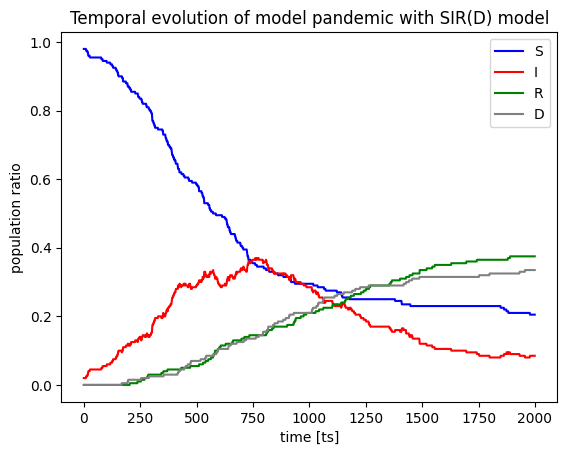

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

# Proportion of susceptible agents
susceptible_pop = [agent_states[:, t].tolist().count(1)/N for t in range(agent_states.shape[1])]
# Proportion of infected agents
infected_pop = [agent_states[:, t].tolist().count(2)/N for t in range(agent_states.shape[1])]
# Proportion of Recovered agents
recovered_pop = [agent_states[:, t].tolist().count(3)/N for t in range(agent_states.shape[1])]
# Proportion of Dead agents
dead_pop = [agent_states[:, t].tolist().count(-1)/N for t in range(agent_states.shape[1])]

plt.plot(susceptible_pop, c="blue", label="S")
plt.plot(infected_pop, c="red", label="I")
plt.plot(recovered_pop, c="green", label="R")
plt.plot(dead_pop, c="gray", label="D")

plt.legend()
plt.xlabel("time [ts]")
plt.ylabel("population ratio")
plt.title("Temporal evolution of model pandemic with SIR(D) model")

## Excercises for Track 2

  -  